In [1]:
""" Based on https://ceur-ws.org/Vol-3290/short_paper5571.pdf """
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

/home/musashishi/Documents/football-beauty/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/bin/bash: line 1: nvcc: command not found
torch:  1.13 ; cuda:  cu117
detectron2: 0.6


In [2]:
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

# Import some common libraries
import cv2 # images
import matplotlib.pyplot as plt

# Import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## Extract 1 person images

### Test section

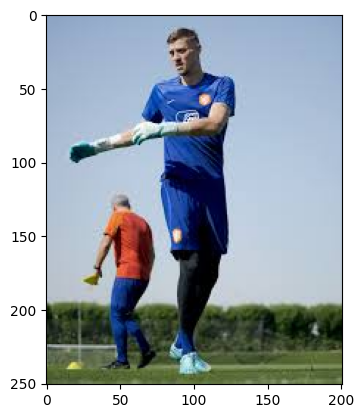

In [3]:
# Test showing image
image_ = cv2.imread("data/Images/Group A/Netherland Players/Images_Andries Noppert/Andries Noppert1.jpg")
image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)

plt.imshow(image_)
plt.show()

In [4]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.predictor.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(image_)

[02/10 14:32:47 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


/home/musashishi/Documents/football-beauty/venv/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([ 0,  0, 34], device='cuda:0')
Boxes(tensor([[ 28.6785, 121.2577,  75.4079, 241.3766],
        [ 26.6533,   9.9111, 128.3151, 244.3974],
        [ 16.7857,  63.7713, 126.5705,  97.8452]], device='cuda:0'))


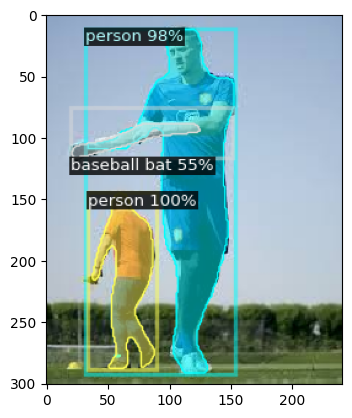

In [6]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(image_[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

plt.imshow(image_)
plt.imshow(out.get_image()[:, :, ::-1])
plt.show()

In [7]:
# Use deterctron2's model_zoo to find images with only 1 person in them (single test person), class 0 is person
outputs["instances"].pred_classes.tolist().count(0)

2

In [8]:
def getImagePaths(path):
    """ Returns a list of all image paths in a directory """
    import os
    image_paths = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".jpg"):
                image_paths.append(os.path.join(root, file))
    return image_paths

In [9]:
paths_ = getImagePaths("data/Images/Group A/Netherland Players/Images_Andries Noppert")
paths_

['data/Images/Group A/Netherland Players/Images_Andries Noppert/Andries Noppert50.jpg',
 'data/Images/Group A/Netherland Players/Images_Andries Noppert/Andries Noppert40.jpg',
 'data/Images/Group A/Netherland Players/Images_Andries Noppert/Andries Noppert49.jpg',
 'data/Images/Group A/Netherland Players/Images_Andries Noppert/Andries Noppert45.jpg',
 'data/Images/Group A/Netherland Players/Images_Andries Noppert/Andries Noppert44.jpg',
 'data/Images/Group A/Netherland Players/Images_Andries Noppert/Andries Noppert24.jpg',
 'data/Images/Group A/Netherland Players/Images_Andries Noppert/Andries Noppert19.jpg',
 'data/Images/Group A/Netherland Players/Images_Andries Noppert/Andries Noppert8.jpg',
 'data/Images/Group A/Netherland Players/Images_Andries Noppert/Andries Noppert2.jpg',
 'data/Images/Group A/Netherland Players/Images_Andries Noppert/Andries Noppert28.jpg',
 'data/Images/Group A/Netherland Players/Images_Andries Noppert/Andries Noppert38.jpg',
 'data/Images/Group A/Netherland P

In [10]:
def getSinglePersonImages(paths):
    """ Returns a list of images with only 1 person in them """
    single_person_images = []
    for path in paths:
        image_ = cv2.imread(path)
        image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
        outputs = predictor(image_)
        if outputs["instances"].pred_classes.tolist().count(0) == 1:
            single_person_images.append(path)
    return single_person_images

In [11]:
images_singles_ = getSinglePersonImages(paths_)
print("Number of Andries Noppert's single-person images", len(images_singles_))
print("Percentage of Andries Noppert's single-person images", len(images_singles_)/len(paths_))

Number of Andries Noppert's single-person images 23
Percentage of Andries Noppert's single-person images 0.46


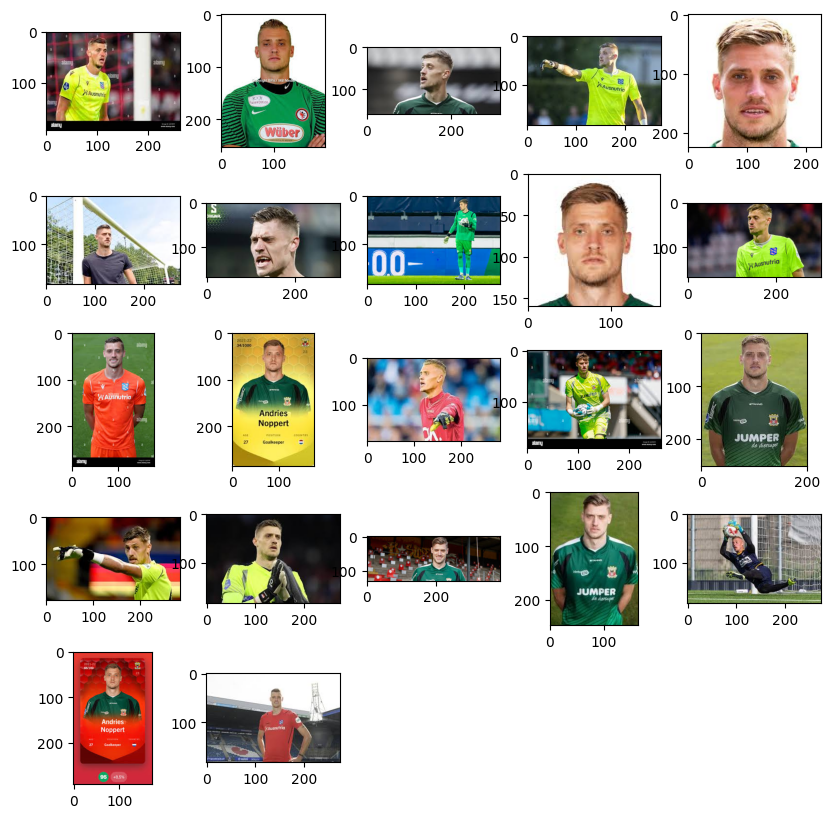

In [12]:
# Display single person images in a grid
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig = plt.figure(figsize=(10, 10))
columns = 5
rows = 5
for i in range(1, len(images_singles_)):
    img = mpimg.imread(images_singles_[i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)

## Actual

In [46]:
# # Get single-person photos for all people in the dataset, and save to a nested dictionary where the first key is the Group and the second key is the player name
# import os
# seen_dirs = []
# def getSinglePersonImagesForAllPlayers(path):
#     """ Returns a dictionary of all single-person images for all players in a directory """
#     single_person_images = {}
#     for root, dirs, files in os.walk(path):
#         for dir in dirs:
#             if dir not in seen_dirs:
#                 print("Getting single-person images for", dir)
#                 seen_dirs.append(dir)
#             single_person_images[dir] = getSinglePersonImages(getImagePaths(os.path.join(root, dir)))
#             break
#         break
#     return single_person_images

# single_person_images = getSinglePersonImagesForAllPlayers("data/Images/")


all_paths_ = getImagePaths("data/Images/")
all_single_person_ = getSinglePersonImages(all_paths_)
print("Number of single-person images", len(all_single_person_))
print("Percentage of single-person images", len(all_single_person_)/len(all_paths_))

Number of single-person images 20344
Percentage of single-person images 0.49009877138039026


In [57]:
# save single-person images paths to a dataframe
import pandas as pd
import re

groups = [re.split("/", path)[2] for path in all_single_person_] # get group name from path
country = [re.split("/", path)[3] for path in all_single_person_] # get country name from path
name = [re.split("/", path)[4] for path in all_single_person_] # get player name from path
image = [re.split("/", path)[5] for path in all_single_person_] # get image name from path

df = pd.DataFrame(list(zip(groups, country, name, image, all_single_person_)), columns=['Group', 'Country', 'Name', 'Image', 'Path'])
print(len(df))
df.sort_values(by=['Group', 'Country', 'Name', 'Image'], inplace=True)
df.reset_index(drop=True, inplace=True)

# save dataframe to csv
df.to_csv("single_person_paths.csv", index=False)

20344


In [58]:
# Load saved csv
df = pd.read_csv("single_person_paths.csv")
df

Group          Country                  Name                Image  \
0      Group A  Ecuador Players    Images_Alan Franco     Alan Franco1.jpg   
1      Group A  Ecuador Players    Images_Alan Franco    Alan Franco12.jpg   
2      Group A  Ecuador Players    Images_Alan Franco    Alan Franco14.jpg   
3      Group A  Ecuador Players    Images_Alan Franco    Alan Franco18.jpg   
4      Group A  Ecuador Players    Images_Alan Franco     Alan Franco2.jpg   
...        ...              ...                   ...                  ...   
20339  Group H  Uruguay Players  Images_Sergio Rochet  Sergio Rochet47.jpg   
20340  Group H  Uruguay Players  Images_Sergio Rochet  Sergio Rochet48.jpg   
20341  Group H  Uruguay Players  Images_Sergio Rochet   Sergio Rochet7.jpg   
20342  Group H  Uruguay Players  Images_Sergio Rochet   Sergio Rochet8.jpg   
20343  Group H  Uruguay Players  Images_Sergio Rochet   Sergio Rochet9.jpg   

                                                    Path  
0      data/Images/Group A/Ecuador Players/Images_Ala...  
1      data/Images/Group A/Ecuador Players/Images_Ala...  
2      data/Images/Group A/Ecuador Players/Images_Ala...  
3      data/Images/Group A/Ecuador Players/Images_Ala...  
4      data/Images/Group A/Ecuador Players/Images_Ala...  
...                                                  ...  
20339  data/Images/Group H/Uruguay Players/Images_Ser...  
20340  data/Images/Group H/Uruguay Players/Images_Ser...  
20341  data/Images/Group H/Uruguay Players/Images_Ser...  
20342  data/Images/Group H/Uruguay Players/Images_Ser...  
20343  data/Images/Group H/Uruguay Players/Images_Ser...  

[20344 rows x 5 columns]

### Check that saving the df worked

data/Images/Group F/Canada Players/Images_Jonathan Osorio/Jonathan Osorio40.jpg


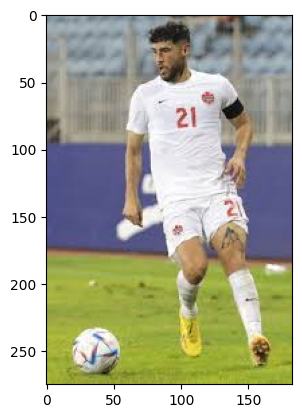

In [59]:
# Randomly select a path from the dataframe and display the image
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

path = random.choice(df['Path'])
print(path)
img = mpimg.imread(path)
plt.imshow(img)


tensor([0], device='cuda:0')
Boxes(tensor([[ 53.3267,   0.0000, 163.9458, 262.5056]], device='cuda:0'))


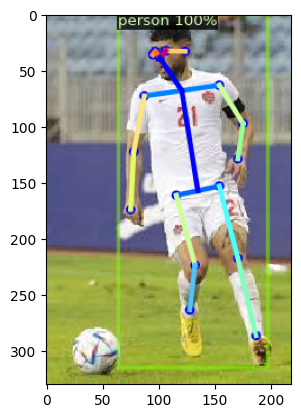

In [74]:
# predict the classes in the image using detectron2
image_ = cv2.imread(path)
image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
outputs = predictor(image_)
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(image_[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

plt.imshow(image_)
plt.imshow(out.get_image()[:, :, ::-1])
plt.show()

In [78]:
outputs["instances"].pred_boxes.tensor.tolist()[0]

[53.32666778564453, 0.0, 163.94581604003906, 262.50555419921875]

# Proportion of person in the image

## Function writing & testing

In [81]:
# Find how much of the image the person is taking up using detectron2
import numpy as np
import cv2
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo

# Find the percentage of the image that the person is taking up using detectron2
def getPersonPercentage(path):
    """ Returns the percentage of the image that the person is taking up """
    image_ = cv2.imread(path)
    image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
    outputs = predictor(image_)
    if outputs["instances"].pred_classes.tolist().count(0) == 1:
        person = outputs["instances"].pred_boxes.tensor.tolist()[0]
        x1, y1, x2, y2 = person[0], person[1], person[2], person[3]


        # Find the percentage of the image that the person is taking up
        image_height, image_width, _ = image_.shape
        person_height = y2 - y1
        person_width = x2 - x1
        person_area = person_height * person_width
        image_area = image_height * image_width
        percentage = person_area/image_area
        return percentage
    else:
        print(f"No person found in image in {path}")
        return None

getPersonPercentage(path)

0.5770122368120294

## Get all single-person images proportions

In [82]:
# For rows in the dataframe, find the percentage of the image that the person is taking up and save that as a new column called "PersonPercentage"
df['PersonPercentage'] = df['Path'].apply(getPersonPercentage)
df.head()

Group          Country                Name              Image  \
0  Group A  Ecuador Players  Images_Alan Franco   Alan Franco1.jpg   
1  Group A  Ecuador Players  Images_Alan Franco  Alan Franco12.jpg   
2  Group A  Ecuador Players  Images_Alan Franco  Alan Franco14.jpg   
3  Group A  Ecuador Players  Images_Alan Franco  Alan Franco18.jpg   
4  Group A  Ecuador Players  Images_Alan Franco   Alan Franco2.jpg   

                                                Path  PersonPercentage  
0  data/Images/Group A/Ecuador Players/Images_Ala...          0.700650  
1  data/Images/Group A/Ecuador Players/Images_Ala...          0.759751  
2  data/Images/Group A/Ecuador Players/Images_Ala...          0.953451  
3  data/Images/Group A/Ecuador Players/Images_Ala...          0.436288  
4  data/Images/Group A/Ecuador Players/Images_Ala...          0.352510

In [83]:
print(df.iloc[2].Path, df.iloc[2].PersonPercentage)
print(df.iloc[4].Path, df.iloc[4].PersonPercentage)

data/Images/Group A/Ecuador Players/Images_Alan Franco/Alan Franco14.jpg 0.9534509505146439
data/Images/Group A/Ecuador Players/Images_Alan Franco/Alan Franco2.jpg 0.3525103962450703


data/Images/Group A/Ecuador Players/Images_Alan Franco/Alan Franco14.jpg
0.9534509505146439


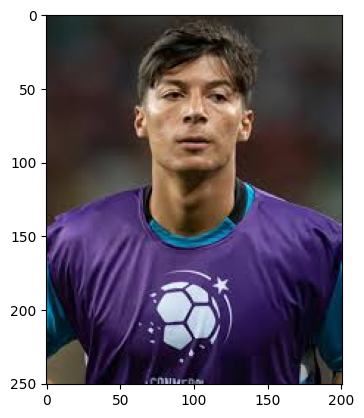

In [84]:
# Print the image from the input path and the percentage of the image that the person is taking up
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

path = df.iloc[2].Path
print(path)
img = mpimg.imread(path)
plt.imshow(img)
print(df.iloc[2].PersonPercentage)

data/Images/Group A/Ecuador Players/Images_Alan Franco/Alan Franco2.jpg
0.3525103962450703


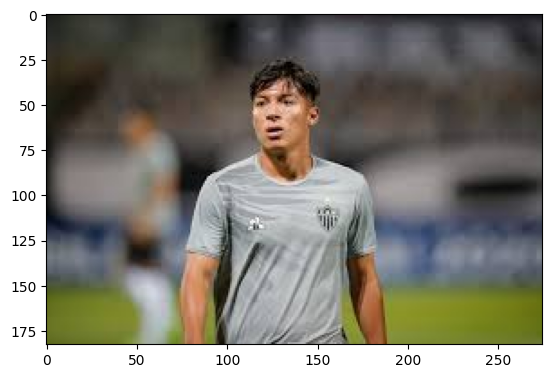

In [85]:
path = df.iloc[4].Path
print(path)
img = mpimg.imread(path)
plt.imshow(img)
print(df.iloc[4].PersonPercentage)

In [86]:
# Update the saved csv
df.to_csv("single_person_paths.csv", index=False)

## Distribution plot of the percentages

In [2]:
# Load saved csv
import pandas as pd
df = pd.read_csv("single_person_paths.csv")

/tmp/ipykernel_9732/1421321938.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['PersonPercentage'])


<AxesSubplot: xlabel='PersonPercentage', ylabel='Density'>

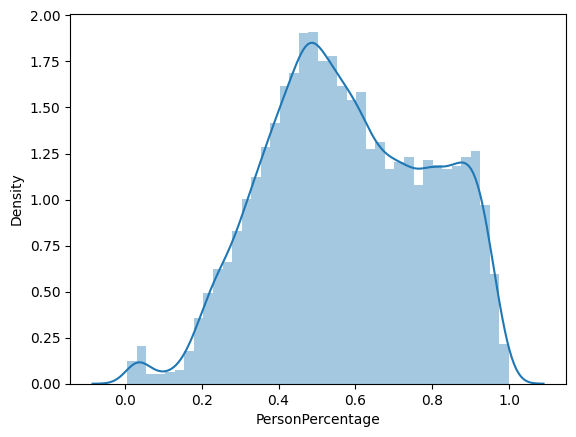

In [87]:
# Draw a distribution plot of the PersonPercentage column
import seaborn as sns
sns.distplot(df['PersonPercentage'])


Highest local peaks are around 0.4-0.5 and 0.85-0.95 

In [4]:
# Add another column to the dataframe called Predominant which is set to True if the PersonPercentage is greater than 0.85 and False otherwise
df['Predominant'] = df['PersonPercentage'].apply(lambda x: True if x > 0.85 else False)

# Save the updated dataframe to a csv
df.to_csv("single_person_paths.csv", index=False)

In [98]:
# Print the number of images where the person is predominant and the number where the person is not predominant
print(f"Number of images where the person is predominant\n{len(df[df['Predominant'] == True])}")
print(f"Number of images where the person is not predominant\n{len(df[df['Predominant'] == False])}")

Number of images where the person is predominant
2371
Number of images where the person is not predominant
17973


In [96]:
# Print the unique values in the Name column
print(f"Unique name count\n{df['Name'].nunique()}")

Unique name count
831


2371


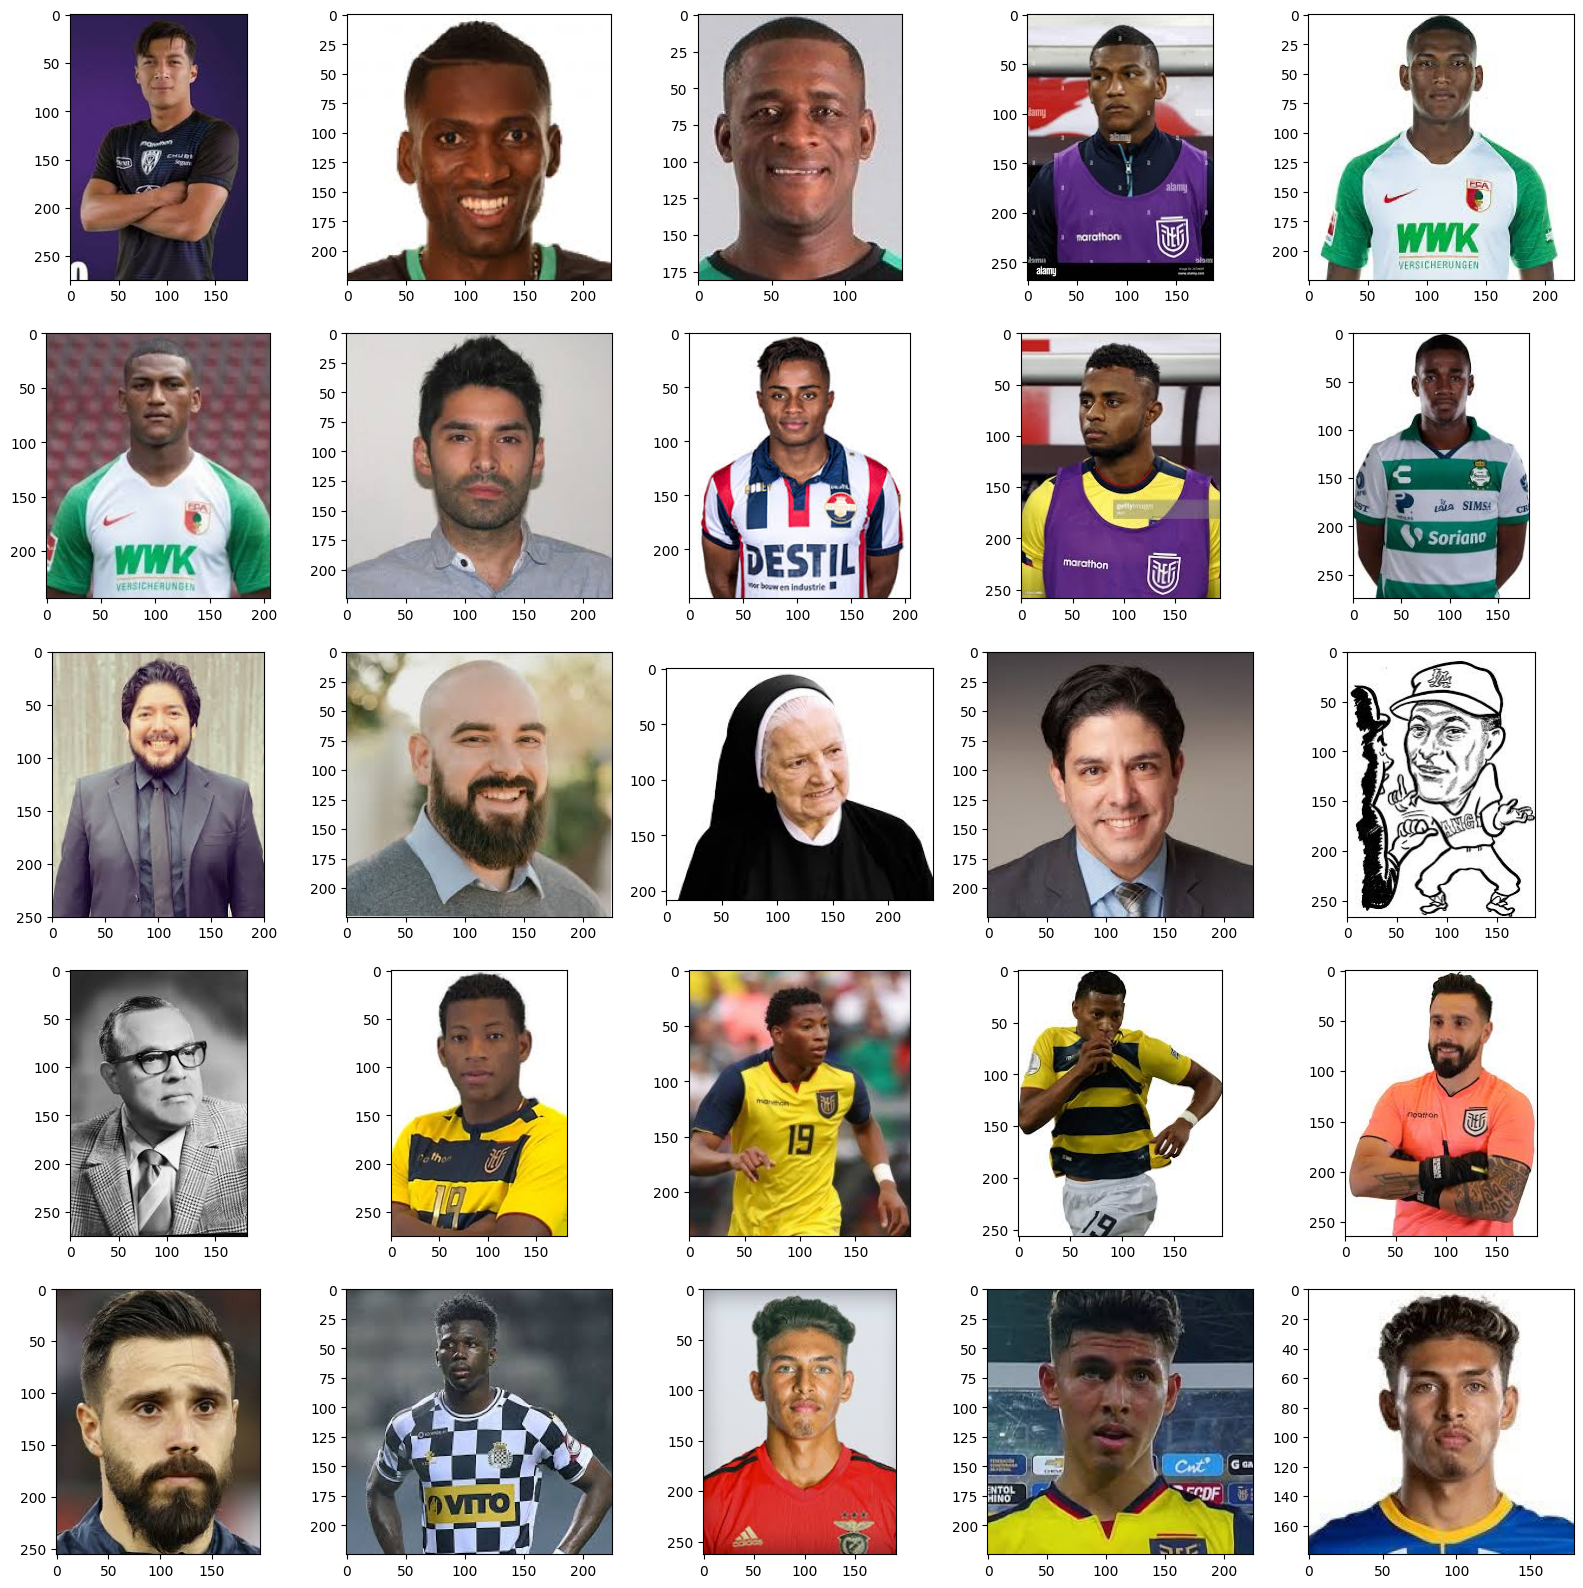

In [6]:
images = df[df['Predominant'] == True]['Path'].tolist()

print(len(images))

# Print all images in a grid
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig = plt.figure(figsize=(20, 20))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    img = mpimg.imread(images[i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

Name: Images_Alan Franco
2


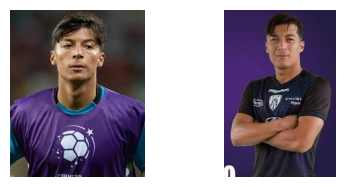

In [100]:
# For the first name in the dataframe, print all images where the person is predominant
name = df.iloc[0].Name
print(f"Name: {name}")

images = df[(df['Name'] == name) & (df['Predominant'] == True)]['Path'].tolist()

print(len(images))
# Print the images in a grid
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig = plt.figure(figsize=(10, 10))
columns = 4

for i, image in enumerate(images):
    img = mpimg.imread(image)
    fig.add_subplot(4, 4, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
# Test the most common densities to see if they are good

In [ ]:
# Use model_zoo again to find the faces' orientations